<a href="https://colab.research.google.com/github/davidsebfischer/scRNAseq_workshop/blob/main/notebooks/BCR_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages

In [ ]:
## https://stackoverflow.com/questions/70025153/how-to-access-the-shell-in-google-colab-when-running-the-r-kernel
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

loadPackages = function(pkgs){
  myrequire = function(...){
    suppressWarnings(suppressMessages(suppressPackageStartupMessages(require(...))))
  }
  ok = sapply(pkgs, require, character.only=TRUE, quietly=TRUE)
  if (!all(ok)){
    message("There are missing packages: ", paste(pkgs[!ok], collapse=", "))
  }
}

## Setup R2U
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
shell_call("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)
shell_call("rm add_cranapt_jammy.sh")

## Install the R packages
cranPkgs2Install = c("BiocManager", "ggpubr", "Seurat", "cowplot",
                     "Rtsne", "hdf5r", "clustree")
install.packages(cranPkgs2Install, ask=FALSE, update=TRUE, quietly=TRUE)
# biocPkgs2Install = c("clusterProfiler", "preprocessCore", "rols",
#                      "scDblFinder","clusterExperiment", "SingleR",
#                      "celldex", "org.Hs.eg.db")
BiocManager::install(version='devel', ask=F)

BiocManager::install("scRepertoire")

52 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
wget is already the newest version (1.21.2-2ubuntu1).
ca-certificates is already the newest version (20230311ubuntu0.22.04.1).
gnupg is already the newest version (2.2.27-3ubuntu2.1).
gnupg set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
-----BEGIN PGP PUBLIC KEY BLOCK-----

mQINBFM+sY8BEADA70T+U0/2WNjOTLvytuXLvBC4vgA8hYvOaBS1cL3d8lu4mwr4
W84/6p4v/mXle/0eIO2D2g+XfK72ZHZxpS+bb7yPxrkCDLGxwUd/khtTJHSbbKFo
J73AsABflMe+8qv+E74+QTiXErTCNioFRz18sa0EvOnEAiokau6TZVYY2z9YjBNI
yEjTi+z+g8c1RL6VmrFEpTicTpafOLbkRyw0VKnAKG7Ytp3Ksc1G9/IAoKw3Q9La
0DJb5iX6hyB7+PNid6htK4LtPKZ2dNSrnRvNNkjj5BgcM2AT1hmxbzHNzIVmPoKA
CQFrkdjog3/PcyjdtZG7cfoSDXrbIAZeAa2ngLv9C/DJatVDd6maPOe66gLo7+As
ErMvO9vtiouqLdurW+Lhx0jFW9Ca3g1taLfbSDyS3X1mOGWcisbQvBqkIuoDQTeS
V4Z04wrwTZ1HtweKG/s5fmPtZNGWVI5YNRLIwdmbGzFTMPu2XTAOd+xSK2H+46Kh
Sh4kFeP6p

Tracing function "install.packages" in package "utils"

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.23), R 4.4.0 (2024-04-24)

Installing package(s) 'BiocVersion'

Installing package(s) 'bit', 'brio', 'bslib', 'callr', 'curl', 'data.table',
  'DBI', 'dbplyr', 'devtools', 'digest', 'farver', 'fs', 'gargle', 'ggplot2',
  'gh', 'gtable', 'highr', 'htmltools', 'httr2', 'isoband', 'knitr', 'munsell',
  'openssl', 'pkgbuild', 'processx', 'ragg', 'remotes', 'rmarkdown',
  'rstudioapi', 'rvest', 'sass', 'stringi', 'systemfonts', 'testthat',
  'textshaping', 'tidyselect', 'tinytex', 'usethis', 'whisker', 'xfun',
  'xopen', 'zip', 'codetools', 'lattice', 'MASS', 'Matrix', 'nlme', 'survival'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")

In [ ]:
## To simplify package loading, we created the loadPackages()
## function. But, if you don't have the function, you should
## use 'library(name_of_package)'
pkgs = c("Rtsne", "Seurat", "tidyverse", "cowplot",
         "scRepertoire","scater")
loadPackages(pkgs)

There are missing packages: scater



# Introduction

<img src="https://camo.githubusercontent.com/f37d3bd3ae082e6e4c9765361d3bf44a4912f909bd701782753484ea4dd1c12e/68747470733a2f2f7777772e626f7263682e6465762f75706c6f6164732f73637265706572746f6972652f7265666572656e63652f666967757265732f73637265706572746f6972655f6865782e706e67" alt="drawing" width="200"/>

Single-cell sequencing is an emerging technology in the field of immunology and oncology that allows researchers to couple RNA quantification and other modalities, like immune cell receptor profiling at the level of an individual cell. A number of workflows and software packages have been created to process and analyze single-cell transcriptomic data. These packages allow users to take the vast dimensionality of the data generated in single-cell-based experiments and distill the data into novel insights. Unlike the transcriptomic field, there is a lack of options for software that allow for single-cell immune receptor profiling. Enabling users to easily combine RNA and immune profiling, the [scRepertoire](https://www.borch.dev/uploads/screpertoire/) framework supports use of 10x, AIRR, BD, MiXCR, Omniscope, TRUST4, and WAT3R single-cell clonal formats and interaction with popular R-based single-cell data pipelines.

Our tutorial below was adapted from the scRepertoire vignettes.


# What data to load into scRepertoire?
scRepertoire functions using the filtered_contig_annotations.csv output from the 10x Genomics Cell Ranger. This file is located in the ./outs/ directory of the VDJ alignment folder. To generate a list of contigs to use for scRepertoire:

load the filtered_contig_annotations.csv for each of the samples.
make a list in the R environment.


```

S1 <- read.csv(".../Sample1/outs/filtered_contig_annotations.csv")
S2 <- read.csv(".../Sample2/outs/filtered_contig_annotations.csv")
S3 <- read.csv(".../Sample3/outs/filtered_contig_annotations.csv")
S4 <- read.csv(".../Sample4/outs/filtered_contig_annotations.csv")

contig_list <- list(S1, S2, S3, S4)


```

## Other alignment workflows
Beyond the default 10x Genomic Cell Ranger pipeline outputs, scRepertoire supports the following single-cell formats:

AIRR
BD Rhapsody Multiomic Immune Profiling
Immcantation
JSON-formatted contig data
MiXCR
Omniscope OS-T/OS-B
Parse Evercode TCR/BCR
TRUST4
WAT3R
loadContigs() can be given a directory where the sequencing experiments are located and it will recursively load and process the contig data based on the file names. Alternatively, loadContigs() can be given a list of data frames and process the contig data



```
#Directory example
contig.output <- c("~/Documents/MyExperiment")
contig.list <- loadContigs(input = contig.output,
                           format = "TRUST4")

#List of data frames example
S1 <- read.csv("~/Documents/MyExperiment/Sample1/outs/barcode_results.csv")
S2 <- read.csv("~/Documents/MyExperiment/Sample2/outs/barcode_results.csv")
S3 <- read.csv("~/Documents/MyExperiment/Sample3/outs/barcode_results.csv")
S4 <- read.csv("~/Documents/MyExperiment/Sample4/outs/barcode_results.csv")

contig_list <- list(S1, S2, S3, S4)
contig.list <- loadContigs(input = contig.output,
                           format = "WAT3R")
```



# Example TCR Data in scRepertoire

scRepertoire comes with a data set from T cells derived from four patients with acute respiratory distress to demonstrate the functionality of the R package. More information on the data set can be found in the corresponding manuscript. The samples consist of paired peripheral-blood (B) and bronchoalveolar lavage (L), effectively creating 8 distinct runs for T cell receptor (TCR) enrichment. We can preview the elements in the list by using the head function and looking at the first contig annotation.

The built-in example data is derived from the 10x Cell Ranger pipeline, so it is ready to go for downstream processing and analysis.

In [ ]:
data("contig_list") #the data built into scRepertoire

head(contig_list[[1]])


,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,AAACCTGAGTACGACG-1,True,AAACCTGAGTACGACG-1_contig_1,True,500,TRA,TRAV25,None,TRAJ20,TRAC,True,True,CGCSNDYKLSF,TGTGGGTGTTCTAACGACTACAAGCTCAGCTTT,8344,4,clonotype123,clonotype123_consensus_2
2,AAACCTGAGTACGACG-1,True,AAACCTGAGTACGACG-1_contig_2,True,478,TRB,TRBV5-1,None,TRBJ2-7,TRBC2,True,True,CASSLTDRTYEQYF,TGCGCCAGCAGCTTGACCGACAGGACCTACGAGCAGTACTTC,65390,38,clonotype123,clonotype123_consensus_1
4,AAACCTGCAACACGCC-1,True,AAACCTGCAACACGCC-1_contig_1,True,506,TRA,TRAV38-2/DV8,None,TRAJ52,TRAC,True,True,CAYRSAQAGGTSYGKLTF,TGTGCTTATAGGAGCGCGCAGGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,18372,8,clonotype124,clonotype124_consensus_1
5,AAACCTGCAACACGCC-1,True,AAACCTGCAACACGCC-1_contig_2,True,470,TRB,TRBV10-3,None,TRBJ2-2,TRBC2,True,True,CAISEQGKGELFF,TGTGCCATCAGTGAACAGGGGAAAGGGGAGCTGTTTTTT,34054,9,clonotype124,clonotype124_consensus_2
6,AAACCTGCAGGCGATA-1,True,AAACCTGCAGGCGATA-1_contig_1,True,558,TRA,TRAV12-1,None,TRAJ9,TRAC,True,True,CVVSDNTGGFKTIF,TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT,5018,2,clonotype1,clonotype1_consensus_2
7,AAACCTGCAGGCGATA-1,True,AAACCTGCAGGCGATA-1_contig_2,True,505,TRB,TRBV9,None,TRBJ2-2,TRBC2,True,True,CASSVRRERANTGELFF,TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT,25110,11,clonotype1,clonotype1_consensus_1


# Combining Contigs into Clones
There are varying definitions of clones or clones in the literature. For the purposes of scRepertoire, we will use clone and define this as the cells with shared/trackable complementarity-determining region 3 (CDR3) sequences. Within this definition, one might use amino acid (aa) sequences of one or both chains to define a clone. Alternatively, we could use nucleotide (nt) or the V(D)JC genes (genes) to define a clone. The latter genes would be a more permissive definition of “clones”, as multiple amino acid or nucleotide sequences can result from the same gene combination. Another option to define clone is the use of the V(D)JC and nucleotide sequence (strict). scRepertoire allows for the use of all these definitions of clones and allows for users to select both or individual chains to examine.

## combineTCR
The output of combineTCR() will be a list of contig data frames that will be reduced to the reads associated with a single cell barcode. It will also combine the multiple reads into clone calls by either the nucleotide sequence (CTnt), amino acid sequence (CTaa), the VDJC gene sequence (CTgene), or the combination of the nucleotide and gene sequence (CTstrict).



In [ ]:
combined.TCR <- combineTCR(contig_list,
                           samples = c("P17B", "P17L", "P18B", "P18L",
                                            "P19B","P19L", "P20B", "P20L"),
                           removeNA = FALSE,
                           removeMulti = FALSE,
                           filterMulti = FALSE)

head(combined.TCR[[1]])

,barcode,sample,TCR1,cdr3_aa1,cdr3_nt1,TCR2,cdr3_aa2,cdr3_nt2,CTgene,CTnt,CTaa,CTstrict
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P17B_AAACCTGAGTACGACG-1,P17B,TRAV25.TRAJ20.TRAC,CGCSNDYKLSF,TGTGGGTGTTCTAACGACTACAAGCTCAGCTTT,TRBV5-1.None.TRBJ2-7.TRBC2,CASSLTDRTYEQYF,TGCGCCAGCAGCTTGACCGACAGGACCTACGAGCAGTACTTC,TRAV25.TRAJ20.TRAC_TRBV5-1.None.TRBJ2-7.TRBC2,TGTGGGTGTTCTAACGACTACAAGCTCAGCTTT_TGCGCCAGCAGCTTGACCGACAGGACCTACGAGCAGTACTTC,CGCSNDYKLSF_CASSLTDRTYEQYF,TRAV25.TRAJ20.TRAC;TGTGGGTGTTCTAACGACTACAAGCTCAGCTTT_TRBV5-1.None.TRBJ2-7.TRBC2;TGCGCCAGCAGCTTGACCGACAGGACCTACGAGCAGTACTTC
3,P17B_AAACCTGCAACACGCC-1,P17B,TRAV38-2/DV8.TRAJ52.TRAC,CAYRSAQAGGTSYGKLTF,TGTGCTTATAGGAGCGCGCAGGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,TRBV10-3.None.TRBJ2-2.TRBC2,CAISEQGKGELFF,TGTGCCATCAGTGAACAGGGGAAAGGGGAGCTGTTTTTT,TRAV38-2/DV8.TRAJ52.TRAC_TRBV10-3.None.TRBJ2-2.TRBC2,TGTGCTTATAGGAGCGCGCAGGCTGGTGGTACTAGCTATGGAAAGCTGACATTT_TGTGCCATCAGTGAACAGGGGAAAGGGGAGCTGTTTTTT,CAYRSAQAGGTSYGKLTF_CAISEQGKGELFF,TRAV38-2/DV8.TRAJ52.TRAC;TGTGCTTATAGGAGCGCGCAGGCTGGTGGTACTAGCTATGGAAAGCTGACATTT_TRBV10-3.None.TRBJ2-2.TRBC2;TGTGCCATCAGTGAACAGGGGAAAGGGGAGCTGTTTTTT
5,P17B_AAACCTGCAGGCGATA-1,P17B,TRAV12-1.TRAJ9.TRAC,CVVSDNTGGFKTIF,TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT,TRBV9.None.TRBJ2-2.TRBC2,CASSVRRERANTGELFF,TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT,TRAV12-1.TRAJ9.TRAC_TRBV9.None.TRBJ2-2.TRBC2,TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT_TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT,CVVSDNTGGFKTIF_CASSVRRERANTGELFF,TRAV12-1.TRAJ9.TRAC;TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT_TRBV9.None.TRBJ2-2.TRBC2;TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT
7,P17B_AAACCTGCATGAGCGA-1,P17B,TRAV12-1.TRAJ9.TRAC,CVVSDNTGGFKTIF,TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT,TRBV9.None.TRBJ2-2.TRBC2,CASSVRRERANTGELFF,TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT,TRAV12-1.TRAJ9.TRAC_TRBV9.None.TRBJ2-2.TRBC2,TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT_TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT,CVVSDNTGGFKTIF_CASSVRRERANTGELFF,TRAV12-1.TRAJ9.TRAC;TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT_TRBV9.None.TRBJ2-2.TRBC2;TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT
9,P17B_AAACGGGAGAGCCCAA-1,P17B,TRAV20.TRAJ8.TRAC,CAVRGEGFQKLVF,TGTGCTGTGCGAGGAGAAGGCTTTCAGAAACTTGTATTT,NA,NA,NA,TRAV20.TRAJ8.TRAC_NA,TGTGCTGTGCGAGGAGAAGGCTTTCAGAAACTTGTATTT_NA,CAVRGEGFQKLVF_NA,TRAV20.TRAJ8.TRAC;TGTGCTGTGCGAGGAGAAGGCTTTCAGAAACTTGTATTT_NA;NA
10,P17B_AAACGGGAGCGTTTAC-1,P17B,TRAV12-1.TRAJ9.TRAC,CVVSDNTGGFKTIF,TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT,TRBV9.None.TRBJ2-2.TRBC2,CASSVRRERANTGELFF,TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT,TRAV12-1.TRAJ9.TRAC_TRBV9.None.TRBJ2-2.TRBC2,TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT_TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT,CVVSDNTGGFKTIF_CASSVRRERANTGELFF,TRAV12-1.TRAJ9.TRAC;TGTGTGGTCTCCGATAATACTGGAGGCTTCAAAACTATCTTT_TRBV9.None.TRBJ2-2.TRBC2;TGTGCCAGCAGCGTAAGGAGGGAAAGGGCGAACACCGGGGAGCTGTTTTTT


## combineBCR
combineBCR() is analogous to combineTCR() with 2 major changes:


1.  Each barcode can only have a maximum of 2 sequences, if greater exists, the 2 with the highest reads are selected;
2.  The strict definition of a clone is based on the normalized Levenshtein edit distance of CDR3 nucleotide sequences and V-gene usage. For more information on this approach, please see the respective citation. This definition allows for the grouping of BCRs derived from the same progenitor that have undergone mutation as part of somatic hypermutation and affinity
maturation.


In [ ]:
BCR.contigs <- read.csv("https://www.borch.dev/uploads/contigs/b_contigs.csv")
combined.BCR <- combineBCR(BCR.contigs,
                           samples = "P1",
                           threshold = 0.85) #the level of similarity in sequences to group together. Default is 0.85.

head(combined.BCR[[1]])

,barcode,sample,IGH,cdr3_aa1,cdr3_nt1,IGLC,cdr3_aa2,cdr3_nt2,CTgene,CTnt,CTaa,CTstrict
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P1_CGGGTCAAGTACGACG-1,P1,None.None.IGHJ1.IGHA2,None,None,IGLV1-44.None.None,None,None,None.None.IGHJ1.IGHA2_IGLV1-44.None.None,None_None,None_None,NA.None_NA.IGLV1-44
2,P1_TCAATCTTCGATAGAA-1,P1,NA,NA,NA,IGLV2-11.IGLJ1.IGLC2,None,None,NA_IGLV2-11.IGLJ1.IGLC2,NA_None,NA_None,NA.NA_NA.IGLV2-11
3,P1_AAACGGGAGCTTATCG-1,P1,IGHV3-23.None.None.None,None,None,IGLV1-47.None.None,None,None,IGHV3-23.None.None.None_IGLV1-47.None.None,None_None,None_None,NA.IGHV3-23_NA.IGLV1-47
4,P1_GTTCATTTCTTTAGGG-1,P1,NA,NA,NA,IGLV2-11.IGLJ1.IGLC1,None,None,NA_IGLV2-11.IGLJ1.IGLC1,NA_None,NA_None,NA.NA_NA.IGLV2-11
5,P1_AGTGAGGGTAAATACG-1,P1,IGHV1-2.IGHD2-21.IGHJ4.IGHG1,CATTSPHVVVVPVADPPPFGHW,TGTGCGACTACGTCTCCACATGTTGTTGTGGTGCCAGTTGCCGATCCCCCCCCCTTTGGCCACTGG,IGLV1-47.None.None,None,None,IGHV1-2.IGHD2-21.IGHJ4.IGHG1_IGLV1-47.None.None,TGTGCGACTACGTCTCCACATGTTGTTGTGGTGCCAGTTGCCGATCCCCCCCCCTTTGGCCACTGG_None,CATTSPHVVVVPVADPPPFGHW_None,IGH:Cluster.6.IGHV1-2_NA.IGLV1-47
6,P1_TCTGAGATCCCTCTTT-1,P1,IGHV3-15.None.None.None,None,None,IGKV2D-28.None.None,None,None,IGHV3-15.None.None.None_IGKV2D-28.None.None,None_None,None_None,NA.IGHV3-15_NA.IGKV2D-28


# (optional) subsetClones
Likewise, we can remove specific list elements after combineTCR() using the subsetClones() function. In order to subset, we need to identify the vector we would like to use for subsetting (name) and the variable values to subset (variables). Below, we isolate just the 2 sequencing results from P18L and P18B.

In [ ]:
subset1 <- subsetClones(combined.TCR,
                        name = "sample",
                        variables = c("P18L", "P18B"))

head(subset1[[1]])

,barcode,sample,TCR1,cdr3_aa1,cdr3_nt1,TCR2,cdr3_aa2,cdr3_nt2,CTgene,CTnt,CTaa,CTstrict
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P18B_AAACCTGAGGCTCAGA-1,P18B,TRAV26-1.TRAJ37.TRAC,CIVRGGSSNTGKLIF,TGCATCGTCAGGGGCGGCTCTAGCAACACAGGCAAACTAATCTTT,TRBV6-1.None.TRBJ2-3.TRBC2,CASIGRSFGRDTQYF,TGTGCCAGTATCGGGAGGTCCTTTGGCCGAGATACGCAGTATTTT,TRAV26-1.TRAJ37.TRAC_TRBV6-1.None.TRBJ2-3.TRBC2,TGCATCGTCAGGGGCGGCTCTAGCAACACAGGCAAACTAATCTTT_TGTGCCAGTATCGGGAGGTCCTTTGGCCGAGATACGCAGTATTTT,CIVRGGSSNTGKLIF_CASIGRSFGRDTQYF,TRAV26-1.TRAJ37.TRAC;TGCATCGTCAGGGGCGGCTCTAGCAACACAGGCAAACTAATCTTT_TRBV6-1.None.TRBJ2-3.TRBC2;TGTGCCAGTATCGGGAGGTCCTTTGGCCGAGATACGCAGTATTTT
3,P18B_AAACCTGCATGACATC-1,P18B,TRAV3.TRAJ20.TRAC,CAVQRSNDYKLSF,TGTGCTGTGCAACGTTCTAACGACTACAAGCTCAGCTTT,TRBV3-1.None.TRBJ2-3.TRBC2,CASSPPRGGFTDTQYF,TGTGCCAGCAGCCCCCCCCGCGGCGGATTCACAGATACGCAGTATTTT,TRAV3.TRAJ20.TRAC_TRBV3-1.None.TRBJ2-3.TRBC2,TGTGCTGTGCAACGTTCTAACGACTACAAGCTCAGCTTT_TGTGCCAGCAGCCCCCCCCGCGGCGGATTCACAGATACGCAGTATTTT,CAVQRSNDYKLSF_CASSPPRGGFTDTQYF,TRAV3.TRAJ20.TRAC;TGTGCTGTGCAACGTTCTAACGACTACAAGCTCAGCTTT_TRBV3-1.None.TRBJ2-3.TRBC2;TGTGCCAGCAGCCCCCCCCGCGGCGGATTCACAGATACGCAGTATTTT
5,P18B_AAACCTGGTATGCTTG-1,P18B,TRAV26-1.TRAJ53.TRAC,CIGSSGGSNYKLTF,TGCATCGGCTCAAGTGGAGGTAGCAACTATAAACTGACATTT,TRBV4-1.None.TRBJ2-2.TRBC2;TRBV19.None.TRBJ1-5.TRBC1,CASSQGGQGGRELFF;CASSYAVGRQPQHF,TGCGCCAGCAGCCAAGGTGGACAGGGCGGAAGGGAGCTGTTTTTT;TGTGCCAGTAGCTACGCGGTGGGGAGGCAGCCCCAGCATTTT,TRAV26-1.TRAJ53.TRAC_TRBV4-1.None.TRBJ2-2.TRBC2;TRBV19.None.TRBJ1-5.TRBC1,TGCATCGGCTCAAGTGGAGGTAGCAACTATAAACTGACATTT_TGCGCCAGCAGCCAAGGTGGACAGGGCGGAAGGGAGCTGTTTTTT;TGTGCCAGTAGCTACGCGGTGGGGAGGCAGCCCCAGCATTTT,CIGSSGGSNYKLTF_CASSQGGQGGRELFF;CASSYAVGRQPQHF,TRAV26-1.TRAJ53.TRAC;TGCATCGGCTCAAGTGGAGGTAGCAACTATAAACTGACATTT_TRBV4-1.None.TRBJ2-2.TRBC2;TRBV19.None.TRBJ1-5.TRBC1;TGCGCCAGCAGCCAAGGTGGACAGGGCGGAAGGGAGCTGTTTTTT;TGTGCCAGTAGCTACGCGGTGGGGAGGCAGCCCCAGCATTTT
8,P18B_AAACGGGCAGATGGGT-1,P18B,NA,NA,NA,TRBV5-1.None.TRBJ1-2.TRBC1,CASSLRETNYGYTF,TGCGCCAGCAGCTTGAGGGAAACCAACTATGGCTACACCTTC,NA_TRBV5-1.None.TRBJ1-2.TRBC1,NA_TGCGCCAGCAGCTTGAGGGAAACCAACTATGGCTACACCTTC,NA_CASSLRETNYGYTF,NA;NA_TRBV5-1.None.TRBJ1-2.TRBC1;TGCGCCAGCAGCTTGAGGGAAACCAACTATGGCTACACCTTC
9,P18B_AAACGGGTCTTACCGC-1,P18B,TRAV20.TRAJ9.TRAC,CAVQAKRYTGGFKTIF,TGTGCTGTGCAGGCCAAGCGGTATACTGGAGGCTTCAAAACTATCTTT,TRBV5-1.None.TRBJ1-1.TRBC1;TRBV7-9.None.TRBJ2-2.TRBC2,CASSLGTGTGVEAFF;CAIDPGLLTGELFF,TGCGCCAGCAGCTTGGGAACGGGGACAGGGGTTGAAGCTTTCTTT;TGTGCCATCGATCCGGGACTACTCACCGGGGAGCTGTTTTTT,TRAV20.TRAJ9.TRAC_TRBV5-1.None.TRBJ1-1.TRBC1;TRBV7-9.None.TRBJ2-2.TRBC2,TGTGCTGTGCAGGCCAAGCGGTATACTGGAGGCTTCAAAACTATCTTT_TGCGCCAGCAGCTTGGGAACGGGGACAGGGGTTGAAGCTTTCTTT;TGTGCCATCGATCCGGGACTACTCACCGGGGAGCTGTTTTTT,CAVQAKRYTGGFKTIF_CASSLGTGTGVEAFF;CAIDPGLLTGELFF,TRAV20.TRAJ9.TRAC;TGTGCTGTGCAGGCCAAGCGGTATACTGGAGGCTTCAAAACTATCTTT_TRBV5-1.None.TRBJ1-1.TRBC1;TRBV7-9.None.TRBJ2-2.TRBC2;TGCGCCAGCAGCTTGGGAACGGGGACAGGGGTTGAAGCTTTCTTT;TGTGCCATCGATCCGGGACTACTCACCGGGGAGCTGTTTTTT
12,P18B_AAAGATGAGTTACGGG-1,P18B,TRAV8-3.TRAJ8.TRAC,CAVGGDTGFQKLVF,TGTGCTGTGGGTGGTGACACAGGCTTTCAGAAACTTGTATTT,TRBV12-4.None.TRBJ1-1.TRBC1,CASRNSQATEAFF,TGTGCCAGCAGAAACTCCCAAGCCACTGAAGCTTTCTTT,TRAV8-3.TRAJ8.TRAC_TRBV12-4.None.TRBJ1-1.TRBC1,TGTGCTGTGGGTGGTGACACAGGCTTTCAGAAACTTGTATTT_TGTGCCAGCAGAAACTCCCAAGCCACTGAAGCTTTCTTT,CAVGGDTGFQKLVF_CASRNSQATEAFF,TRAV8-3.TRAJ8.TRAC;TGTGCTGTGGGTGGTGACACAGGCTTTCAGAAACTTGTATTT_TRBV12-4.None.TRBJ1-1.TRBC1;TGTGCCAGCAGAAACTCCCAAGCCACTGAAGCTTTCTTT


# clonalQuant

The first function to explore the clones is clonalQuant() to return the total or relative numbers of unique clones.

**scale**


*   TRUE - relative percent of unique clones scaled by the total size of the clonal repertoire.
*   FALSE - Report the total number of unique clones (default).

**chain**


*   “both” for combined chain visualization
*   “TRA”, “TRB”, “TRD”, “TRG”, “IGH” or “IGL” to select single chain


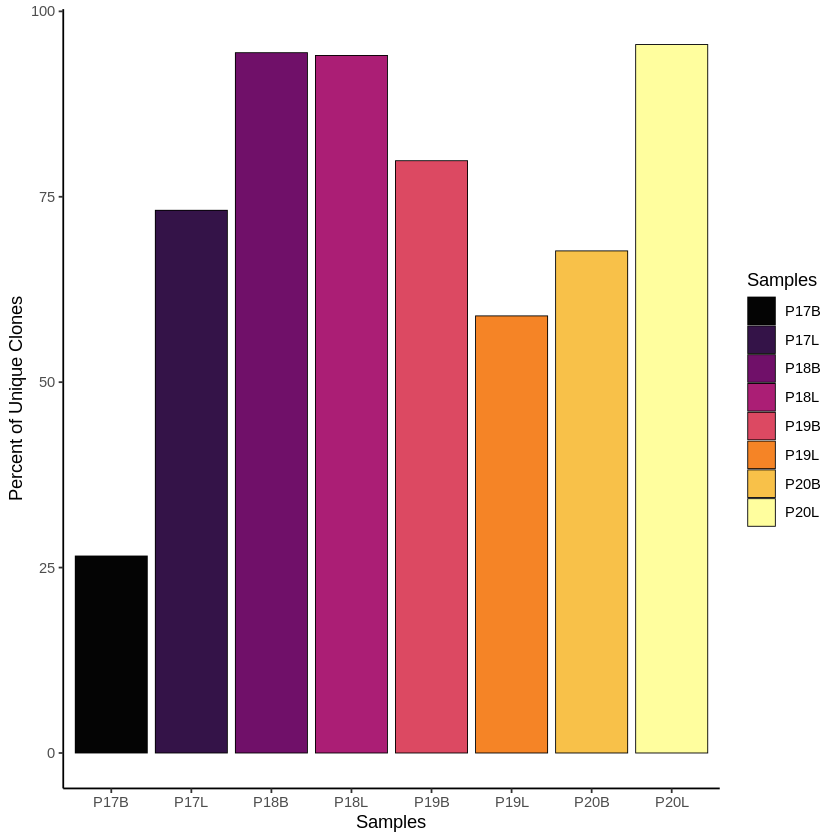

In [ ]:
clonalQuant(combined.TCR,
            cloneCall="strict",
            chain = "both",
            scale = TRUE)


Another option here is to be able to define the visualization by data classes. Here, we used the combineTCR() list to define the Type variable as part of the naming structure. We can use the group.by to specifically use a column in the data set to organize the visualization.



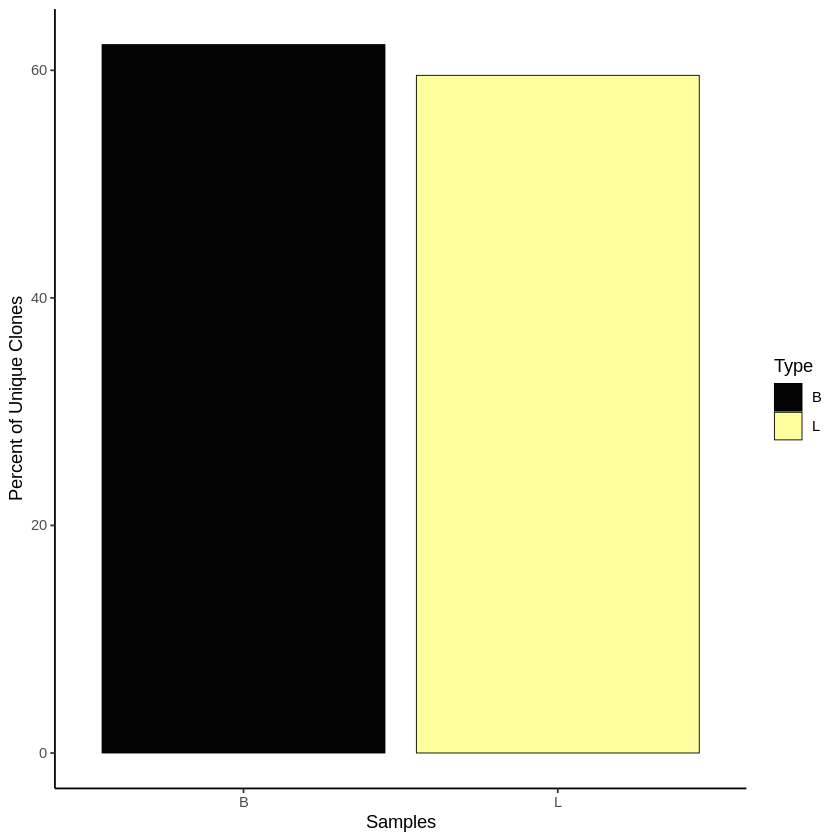

In [ ]:
#add the Type in which the samples were processed and sequenced.
combined.TCR <- addVariable(combined.TCR,
                            variable.name = "Type",
                            variables = rep(c("B", "L"), 4))

clonalQuant(combined.TCR, cloneCall = "gene", group.by = "Type", scale = TRUE)

# clonalLength
We can look at the length distribution of the CDR3 sequences by calling the lengtheContig() function. Importantly, unlike the other basic visualizations, the cloneCall can only be “nt” or “aa”. Due to the method of calling clones as outlined above, the length should reveal a multimodal curve, this is a product of using the NA for the unreturned chain sequence and multiple chains within a single barcode.

**chain**


*   “both” for combined chain visualization
*   “TRA”, “TRB”, “TRD”, “TRG”, “IGH” or “IGL” to select single chain






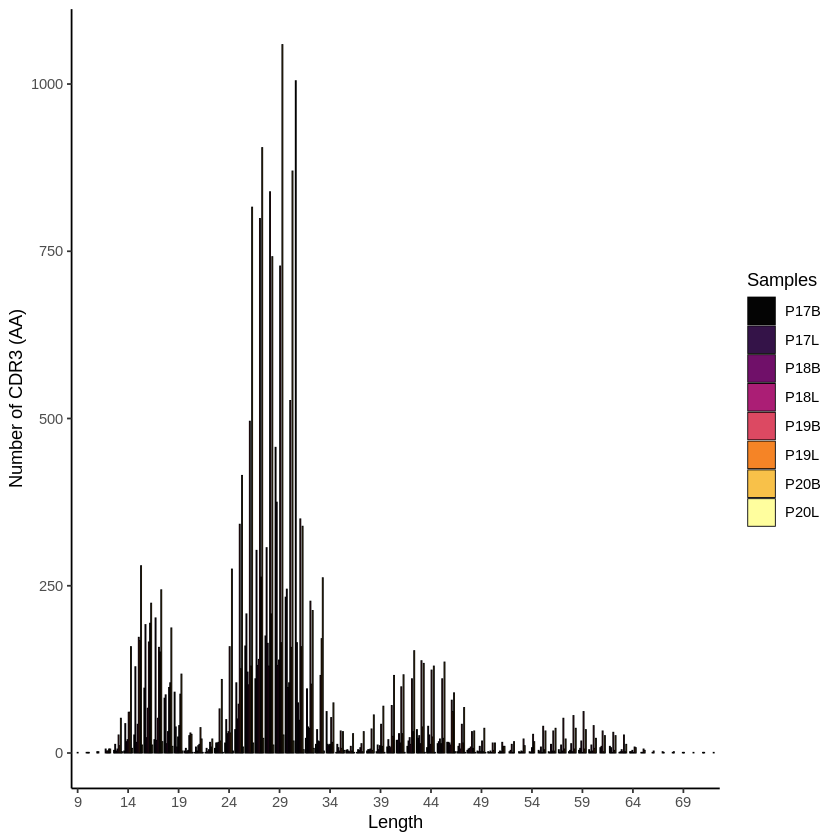

In [ ]:
clonalLength(combined.TCR,
             cloneCall="aa",
             chain = "both")

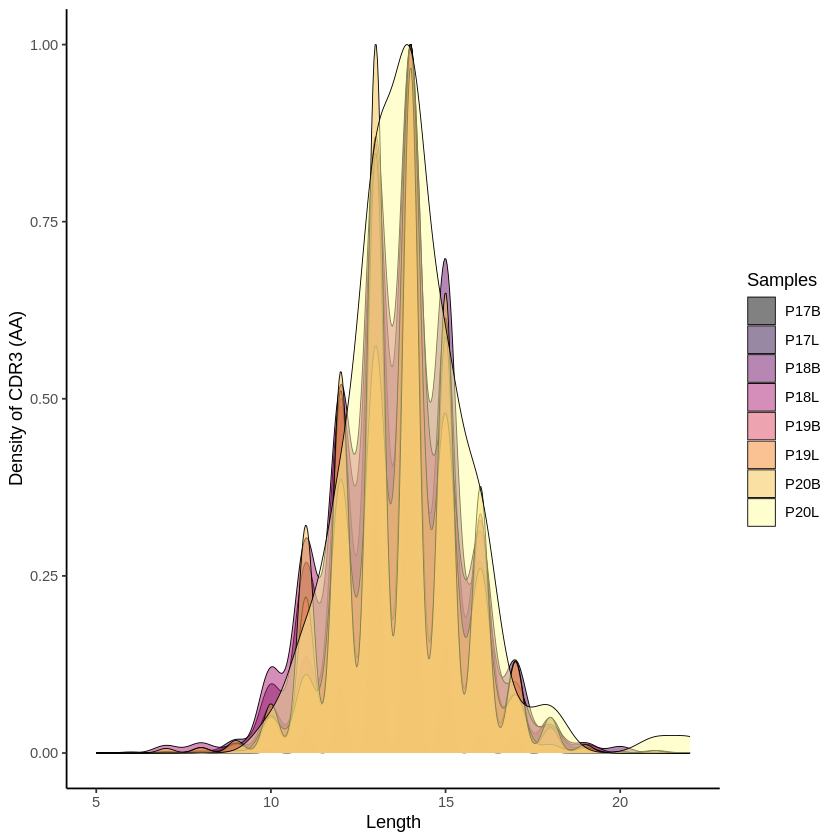

In [ ]:
clonalLength(combined.TCR,
             cloneCall="aa",
             chain = "TRA",
             scale = TRUE)


# clonalCompare
We can also look at clones between samples and changes in dynamics by using the clonalCompare() function.

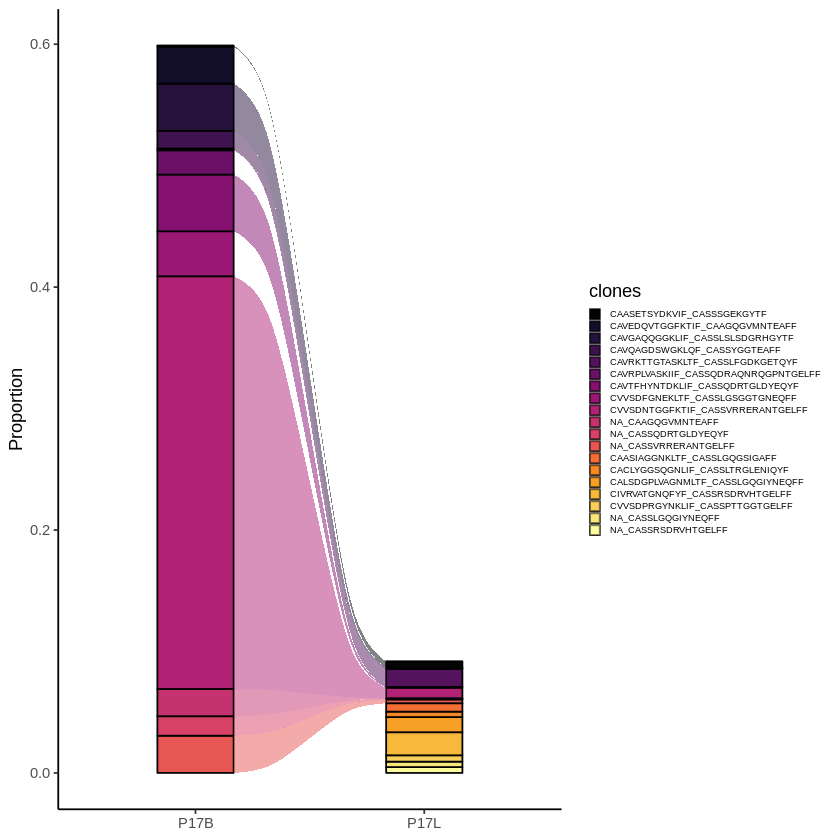

In [ ]:
clonalCompare(combined.TCR,
                  top.clones = 10,
                  samples = c("P17B", "P17L"),
                  cloneCall="aa",
                  graph = "alluvial")

We can also choose to highlight specific clones

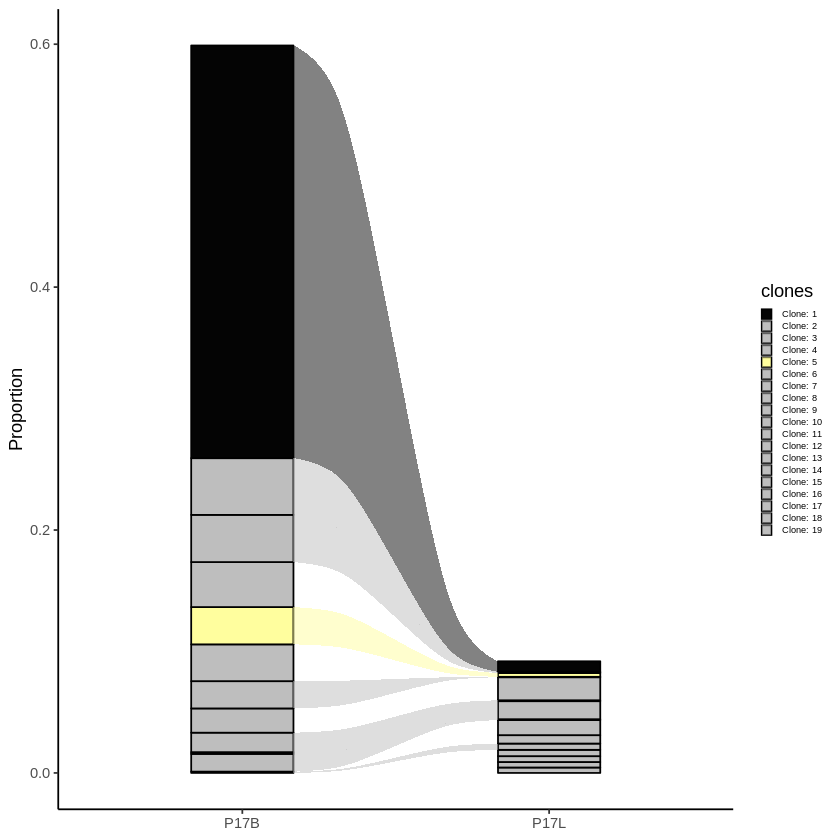

In [ ]:
clonalCompare(combined.TCR,
              top.clones = 10,
              highlight.clones = c("CVVSDNTGGFKTIF_CASSVRRERANTGELFF", "NA_CASSVRRERANTGELFF"),
              relabel.clones = TRUE,
              samples = c("P17B", "P17L"),
              cloneCall="aa",
              graph = "alluvial")

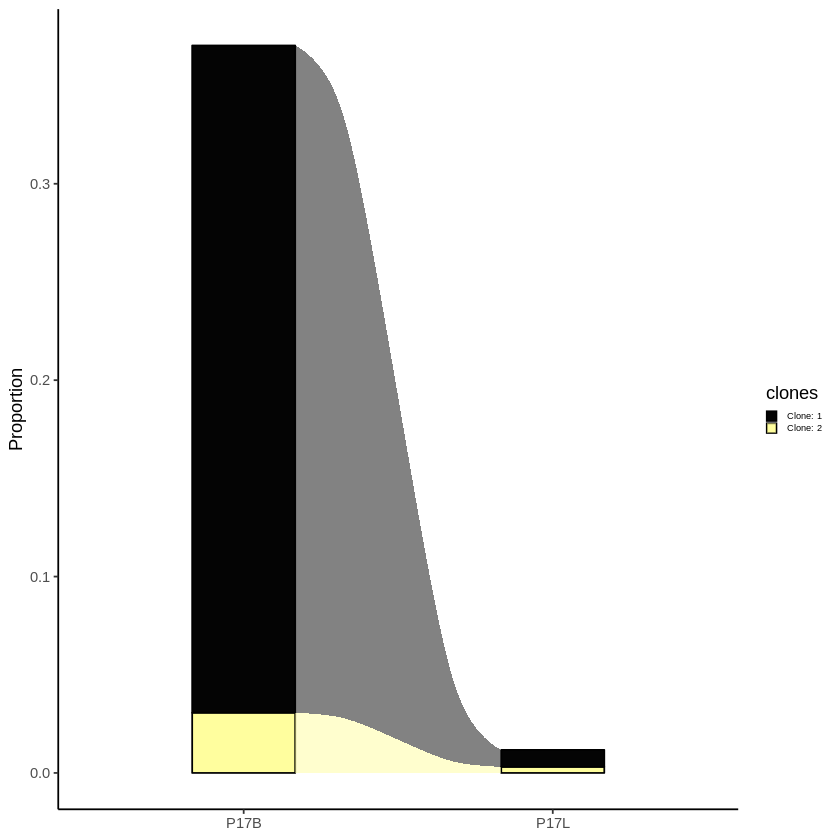

In [ ]:
# show only specific clones
clonalCompare(combined.TCR, clones = c("CVVSDNTGGFKTIF_CASSVRRERANTGELFF", "NA_CASSVRRERANTGELFF"),
    relabel.clones = TRUE, samples = c("P17B", "P17L"), cloneCall = "aa", graph = "alluvial")

# Visualizing Clonal Dynamics
## clonalHomeostasis
By examining the clonal space, we effectively look at the relative space occupied by clones at specific proportions. Another way to think about this would be to think of the total immune receptor sequencing run as a measuring cup. In this cup, we will fill liquids of different viscosity - or different numbers of clonal proportions. Clonal space homeostasis asks what percentage of the cup is filled by clones in distinct proportions (or liquids of different viscosity, to extend the analogy). The proportional cut points are set under the cloneSize variable in the function and can be adjusted.

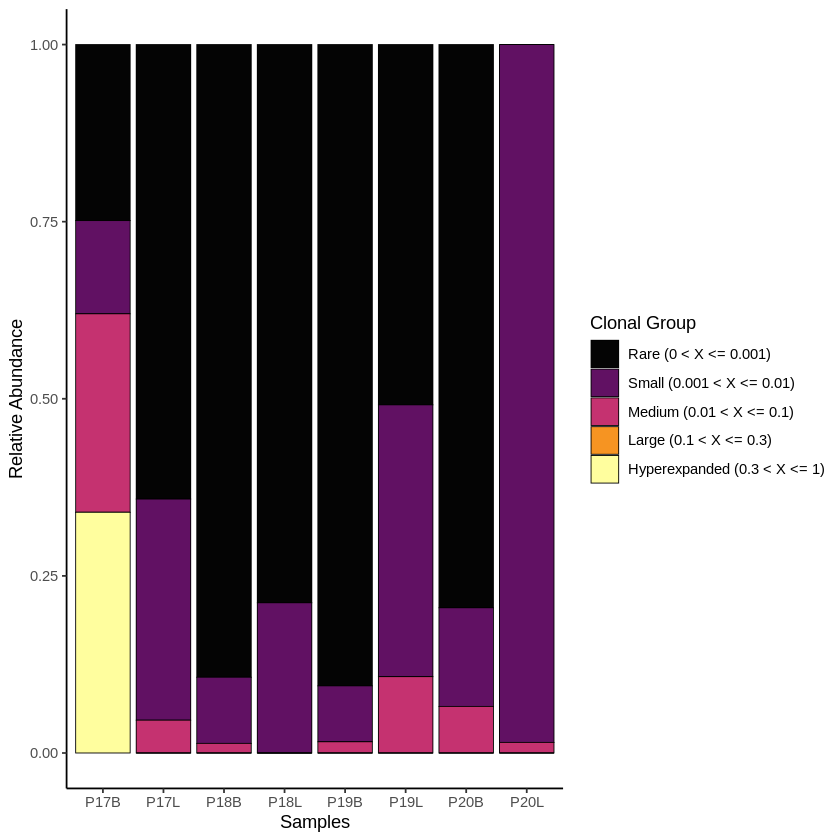

In [ ]:
clonalHomeostasis(combined.TCR,
                  cloneCall = "gene",
                  cloneSize = c(Rare = 0.001, Small = 0.01, Medium = 0.1, Large = 0.3, Hyperexpanded =
    1))

# clonalProportion
Like clonal space homeostasis above, clonal proportion places clones into separate bins. The key difference is that instead of looking at the relative proportion of the clone to the total, the clonalProportion() function will rank the clones by total number and place them into bins.

The clonalSplit represents the ranking of clonotypes by copy or frequency of occurrence, meaning 1:10 are the top 10 clonotypes in each sample. The default bins are under the clonalSplit variable in the function and can be adjusted, but they are as follows at baseline.

**clonalSplit**

*   10
*   100
*   1000
*   10000
*   30000
*   100000


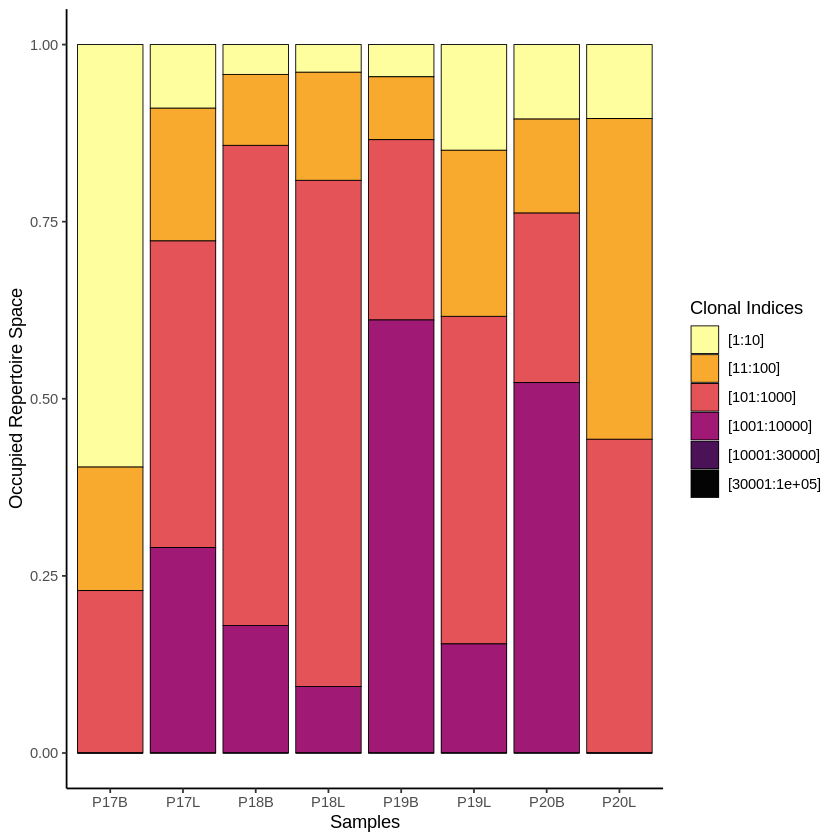

In [ ]:
clonalProportion(combined.TCR,
                 cloneCall = "gene")

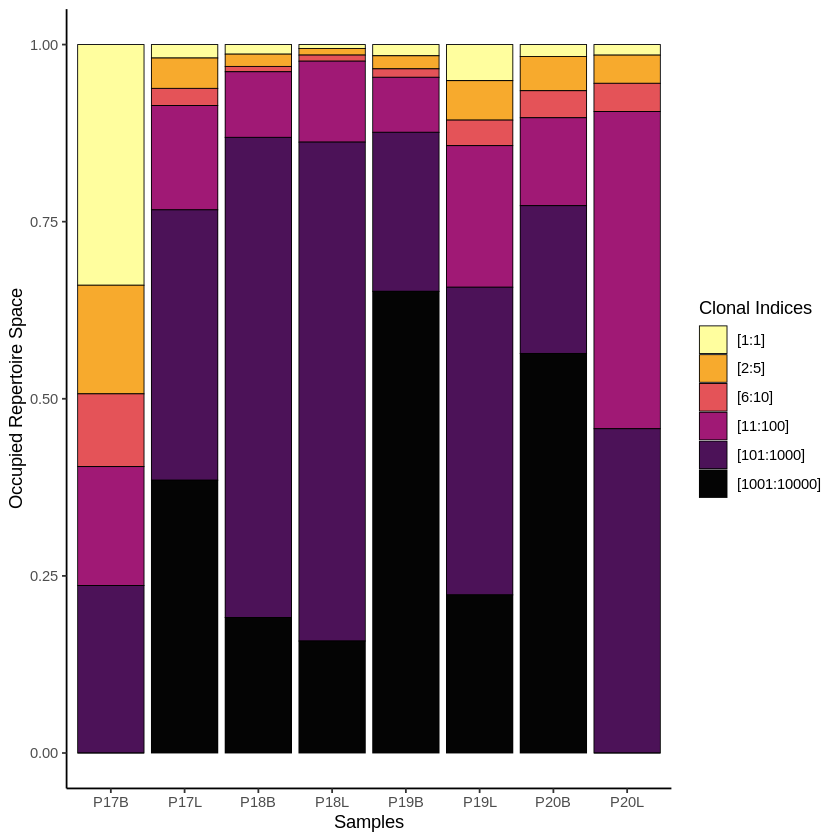

In [ ]:
clonalProportion(combined.TCR,
                 cloneCall = "nt",
                 clonalSplit = c(1, 5, 10, 100, 1000, 10000))

# Summarizing Repertoires
## percentAA
Quantify the proportion of amino acids along the cdr3 sequence with percentAA(). By default, the function will pad the sequences with NAs up to the maximum of aa.length. Sequences longer than aa.length will be removed before visualization (default aa.length = 20).



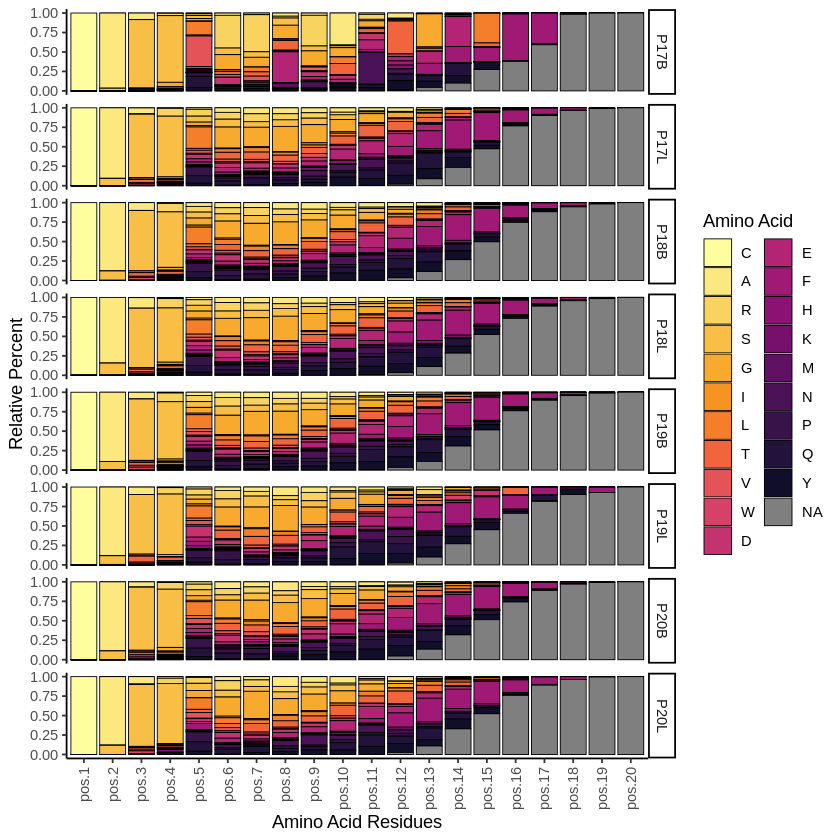

In [ ]:
percentAA(combined.TCR,
          chain = "TRB",
          aa.length = 20)

##positionalEntropy
We can also quantify the level of entropy/diversity across amino acid residues along the cdr3 sequence. positionalEntropy() combines the quantification by residue of percentAA() with the diversity calls in clonalDiversity().

**method**:

“shannon” - Shannon Diversity; “inv.simpson” - Inverse Simpson Diversity;
“norm.entropy” - Normalized Entropy


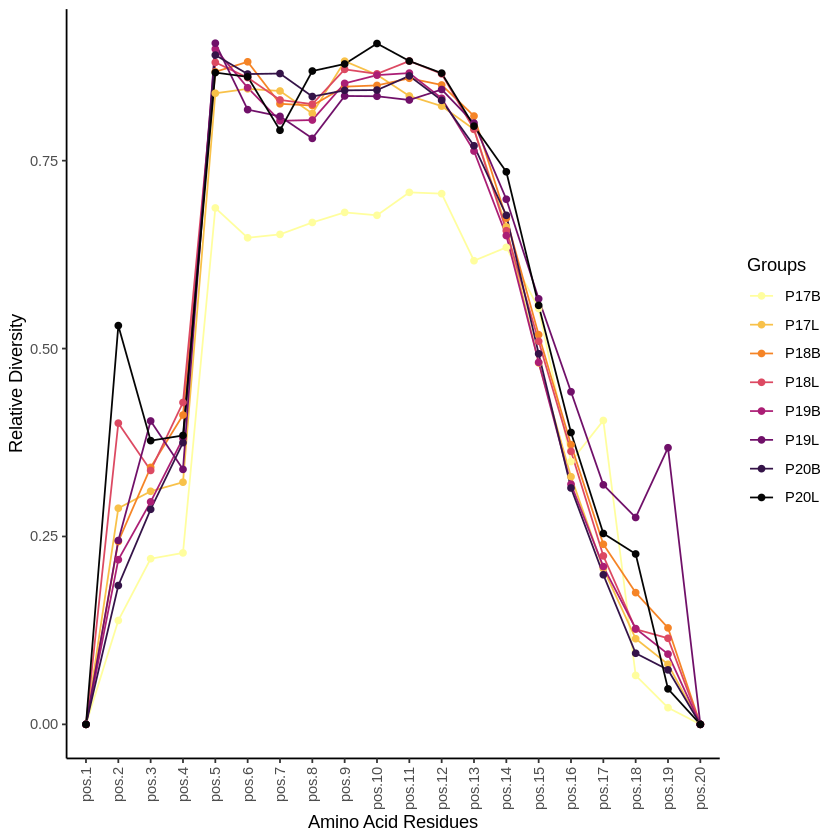

In [ ]:
positionalEntropy(combined.TCR,
                  chain = "TRB",
                  aa.length = 20)

## vizGenes
A visualization of the relative usage of genes of the TCR or BCR, using vizGenes(). vizGenes() is more adaptable to allow for comparisons across chains, scaling, etc, compared to other methods in the package like percentGenes() and percentVJ()

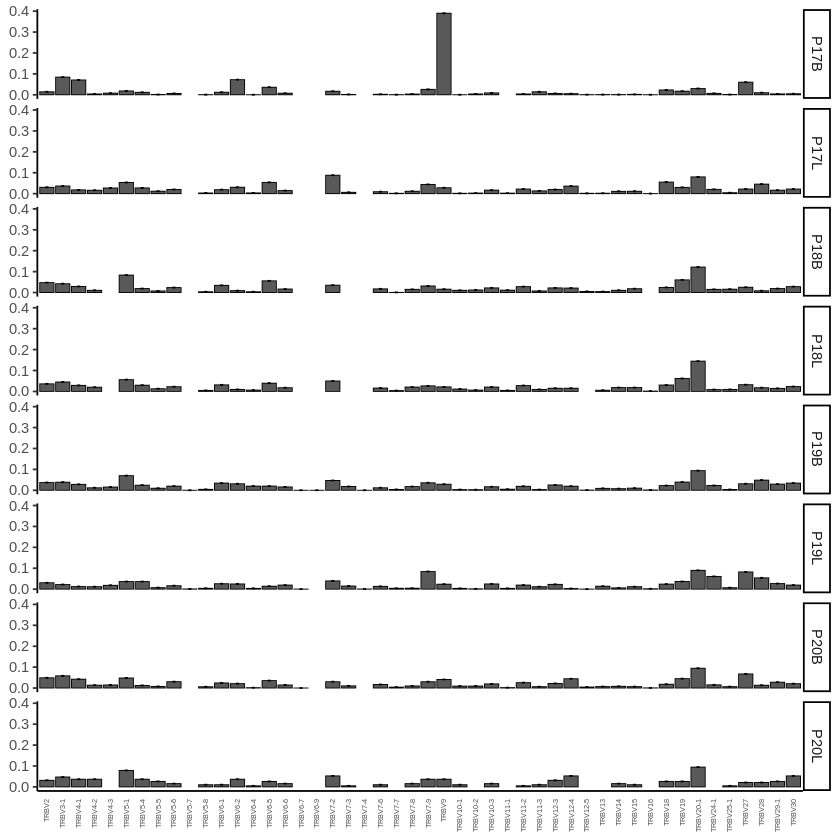

In [ ]:
vizGenes(combined.TCR,
         x.axis = "TRBV",
         y.axis = NULL,
         plot = "barplot",
         scale = TRUE)

#Comparing Clonal Diversity and Overlap


## lonalDiversity
Diversity can also be measured for samples or by other variables. Diversity metrics calculated, include: “shannon”, “inv.simpson”, “norm.entropy”, “gini.simpson”, “chao1”, and “ACE”. Please see the manual for more information on each metric and the underlying calculations.

Inherent in diversity calculations is a bias for increasing diversity with increasing repertoire size. clonalDiversity() will automatically downsample to the smallest repertoire size and perform bootstrapping to return the mean diversity estimates. If the output of diversity values are strange or minimally variable, it is likely due to a sample with small repertoire size.

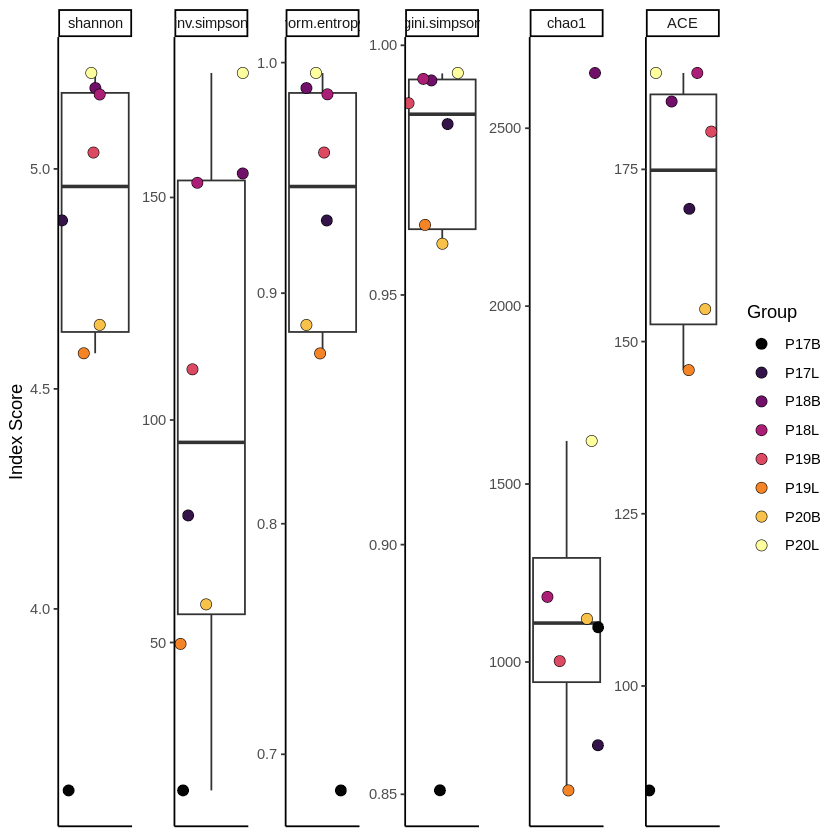

In [ ]:
clonalDiversity(combined.TCR,
                cloneCall = "gene")
#As a default, clonalDiversity() will return all the metrics calculated - “shannon”,
#“inv.simpson”, “norm.entropy”, “gini.simpson”, “chao1”, and “ACE”. Selecting a single or a subset of these methods using the metrics parameter.
# e.g. add 'metrics = c("shannon", "ACE")',

(optional) you can add patient information and group by patient instead

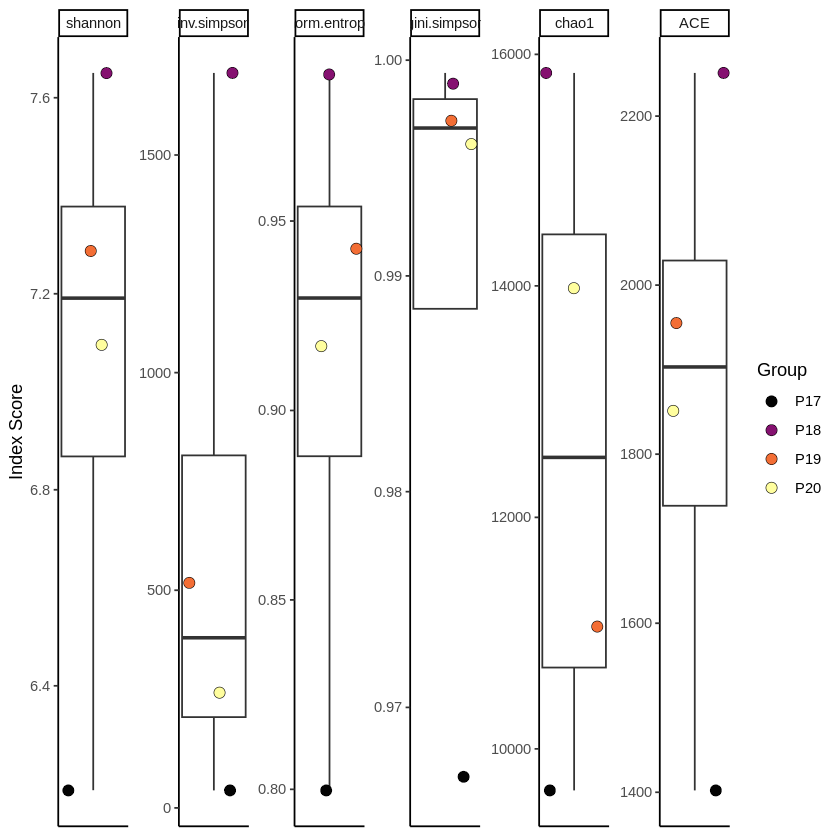

In [ ]:
combined.TCR <- addVariable(combined.TCR,
                            variable.name = "Patient",
                             variables = c("P17", "P17", "P18", "P18",
"P19","P19", "P20", "P20"))

clonalDiversity(combined.TCR,
                cloneCall = "gene",
                group.by = "Patient")

## clonalOverlap
If you are interested in measures of similarity between the samples loaded into scRepertoire, using clonalOverlap() can assist in the visualization.

The underlying clonalOverlap() calculation varies by the method parameter, more information on the exact calculations are available in the manual.
**method**:


*   “overlap” - overlap coefficient
*   “morisita” - Morisita’s overlap index
*   “jaccard” - Jaccard index
*   “cosine” - cosine similarity
*   “raw” - exact number of overlapping clones



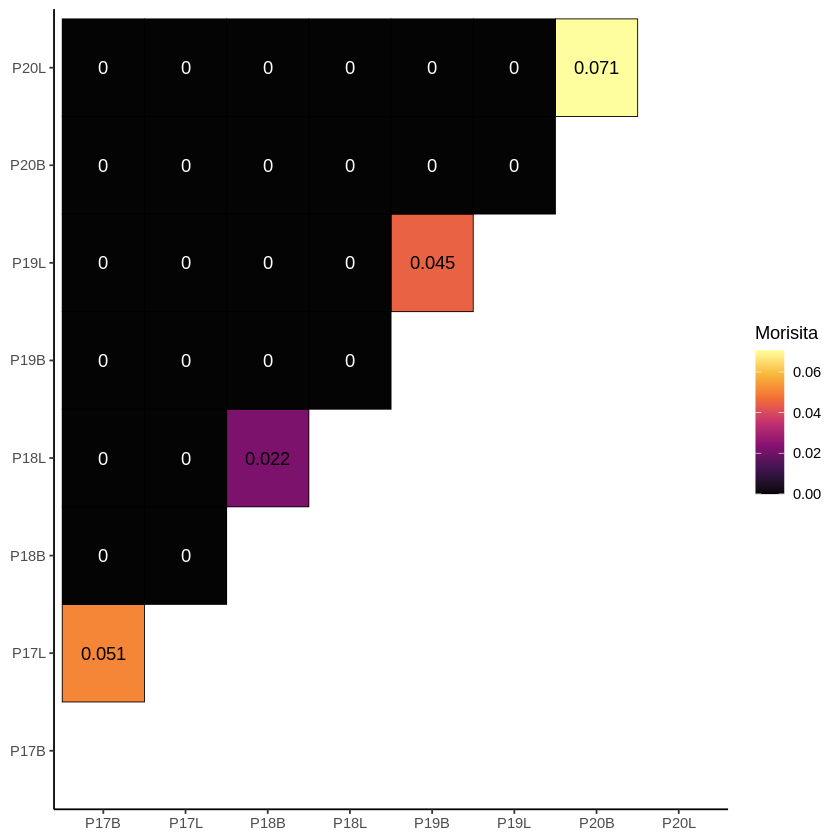

In [ ]:
clonalOverlap(combined.TCR,
              cloneCall = "strict",
              method = "morisita")

Leave cluster by edit distance for now:
https://www.borch.dev/uploads/screpertoire/articles/clonal_cluster

#Combining Clones and Single-Cell Objects


In [ ]:
shell_call('wget -q --output-document scRep_example_full.rds https://www.dropbox.com/scl/fi/birssjr9zivzsqnt5as24/scRep_example_full.rds?rlkey=fajir2r8mj5374ubr6qs18q9v&dl=0')

## combineExpression and calculating cloneSize
After processing the contig data into clones via combineBCR() or combineTCR(), we can add the clonal information to the single-cell object using combineExpression().

Part of combineExpression() is calculating the clonal frequency and proportion, placing each clone into groups called cloneSize. The default cloneSize argument uses the following bins: c(Rare = 1e-4, Small = 0.001, Medium = 0.01, Large = 0.1, Hyperexpanded = 1), which can be modified to include more/less bins or different names.

Clonal frequency and proportion is dependent on the repertoires being compared, which we can modify the calculation using the group.by parameter, such as grouping by the Patient variable from above. If group.by is not set, combineExpression() will calculate clonal frequency, proportion, and cloneSize as a function of individual sequencing runs. In addition, cloneSize can use the frequency of clones when proportion = FALSE.

In [ ]:
BiocManager::install("scater")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.23), R 4.4.0 (2024-04-24)

Installing package(s) 'scater'

Old packages: 'farver'



In [ ]:
library(scater)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQR

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


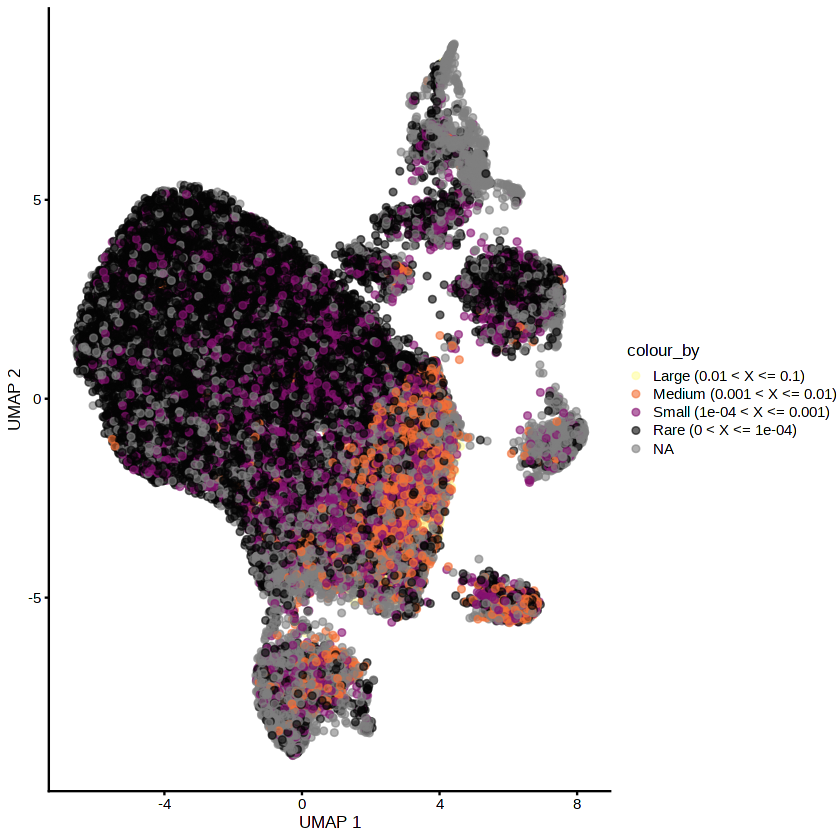

In [ ]:
# download the preprocessed object

scRep_example <- readRDS("scRep_example_full.rds")

#Making a Single-Cell Experiment object
sce <- Seurat::as.SingleCellExperiment(scRep_example)

sce <- combineExpression(combined.TCR,
                         sce,
                         cloneCall="gene",
                         group.by = "sample",
                         proportion = TRUE)

#Define color palette
colorblind_vector <- hcl.colors(n=7, palette = "inferno", fixup = TRUE)

# Visualize UMAP colored by default cloneSize groupings
scater::plotUMAP(sce, colour_by = "cloneSize") +
    scale_color_manual(values=rev(colorblind_vector[c(1,3,5,7)]))



Alternatively, if we want cloneSize to be based on the frequency of the clone, we can set proportion = FALSE and we will need to change the cloneSize bins to integers. If we have not inspected our clone data, setting the upper limit of the clonal frequency might be difficult - combineExpression() will automatically adjust the upper limit to fit the distribution of the frequencies. To demonstrate this, check out the Seurat object below:

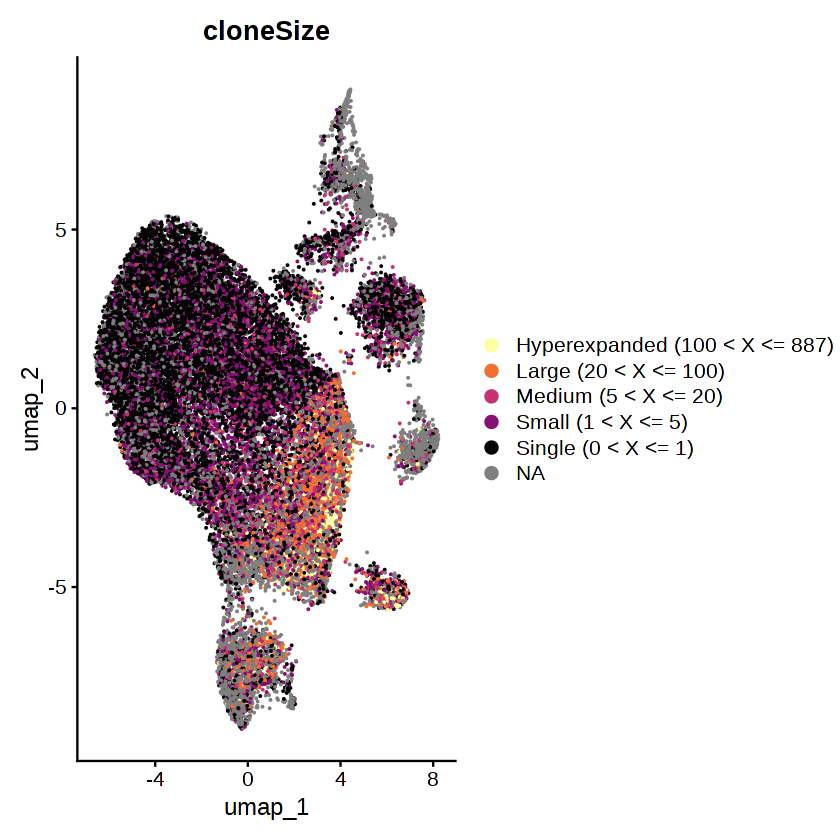

In [ ]:
scRep_example <- combineExpression(combined.TCR,
                                   scRep_example,
                                   cloneCall="gene",
                                   group.by = "sample",
                                   proportion = FALSE,
                                   cloneSize=c(Single=1, Small=5, Medium=20, Large=100, Hyperexpanded=500))

Seurat::DimPlot(scRep_example, group.by = "cloneSize") +
    scale_color_manual(values=rev(colorblind_vector[c(1,3,4,5,7)]))

## clonalOccupy
We can also look at the count of cells by cluster assigned into specific frequency ranges by using the clonalOccupy() function and selecting the x.axis to display cluster or other variables in the meta data of the single cell object.

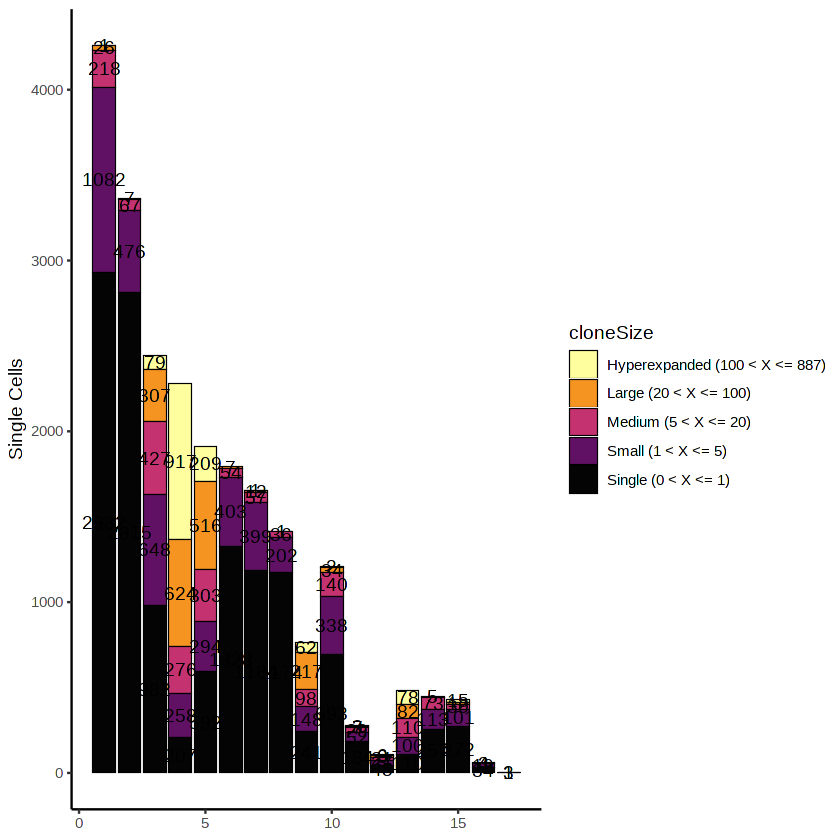

In [ ]:
clonalOccupy(scRep_example,
              x.axis = "seurat_clusters",
              proportion = FALSE, #change to TRUE to look at proportions!
             label = TRUE) #change to FALSE to not label the bars

**Optional but feel free to explore more visualization on single cell data in here https://www.borch.dev/uploads/screpertoire/articles/sc_visualizations**